In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.svm import LinearSVC
from keras.preprocessing import sequence
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import warnings
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import gensim.downloader 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#Utils

In [4]:
def confusionMatrix(test, pred):
  cm = confusion_matrix(test,pred)
  c_matrix=pd.DataFrame(cm,columns=['Negative', 'Somewhat Negative', 'Neutral', 'Somewhat Positive', 'Positive'],index=['Negative', 'Somewhat Negative', 'Neutral', 'Somewhat Positive', 'Positive'])

  fig,ax=plt.subplots(figsize=(10,10))
  sns.set(font_scale=1.4)
  sns.heatmap(c_matrix/np.sum(c_matrix),fmt="0.2%",annot=True,cmap="Blues",ax=ax)
  ax.set_title("Confusion matrix ",fontsize=26)
  ax.set_xlabel("Predicted",fontsize=26)
  ax.set_ylabel("Actual",fontsize=26)

In [5]:
def gridSearchOptimization(model, param, train, test):
  grid = GridSearchCV(model, param, scoring="accuracy", cv=5, n_jobs=-1)
  grid.fit(train,test)
  print("Best parameter set: %s" % grid.best_params_)
  clf = grid.best_estimator_
  return clf

In [6]:
def convert_review(number):
  if(number == 0):
    return "negative"
  if (number == 1):
    return "somewhat negative"
  if (number == 2):
    return "neutral"
  if (number == 3):
    return "somewhat positive"
  if (number == 4):
    return "positive"

In [7]:
def softmax_stable(x):
    return(np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum())

def from_soft_to_class(results):
  predict_class = np.argmax(results, axis=1)
  predict_class = predict_class.tolist()
  return predict_class


In [8]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [9]:
def vocabulary_size(text):

  unique_words = set()
  len_max = 0

  for sent in tqdm(text):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
  return unique_words, len_max

In [10]:
def predict_results(df, model):
  y_pred=model.predict(df)
  y_pred = (y_pred).round(2)
  pred = from_soft_to_class(y_pred)
  return pred

In [32]:
trainD = "train.tsv"
testD = "test.tsv"

In [33]:
dfTrain = pd.read_csv(trainD, delimiter='\t' )

dfTest = pd.read_csv(testD, delimiter="\t")

In [34]:
dfTest.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [35]:
dfTrain.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


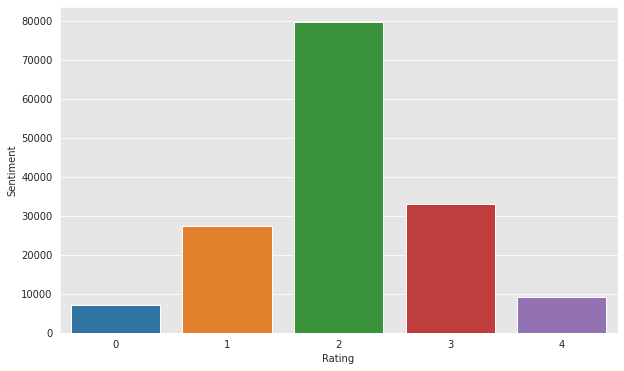

In [36]:
a = dfTrain.Sentiment.value_counts()
a = pd.DataFrame(a)
a['Rating'] = a.index
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(y='Sentiment', x='Rating', data=a)

#Preprocessing Phase

In [39]:
def preprocessing_text(df):

    wn = nltk.WordNetLemmatizer()
    stopword = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(df)
    lower = [word.lower() for word in tokens]
    no_stopwords = [word for word in lower if word not in stopword]
    no_alpha = [word for word in no_stopwords if word.isalpha()]
    lemm_text = [wn.lemmatize(word) for word in no_alpha]
    lemm_textV = [wn.lemmatize(word, 'v') for word in lemm_text]
    clean_text = lemm_textV
    return clean_text
    
    return clean_text



dfTrain['pre_processing'] = dfTrain['Phrase'].map(preprocessing_text)
dfTrain['clean_text']=dfTrain['pre_processing'].apply(lambda x: " ".join([str(word) for word in x]))

dfTest['pre_processing'] = dfTest['Phrase'].map(preprocessing_text)
dfTest['clean_text']=dfTest['pre_processing'].apply(lambda x: " ".join([str(word) for word in x]))

In [40]:
target=dfTrain.Sentiment.values
y_target=to_categorical(target)
num_classes=y_target.shape[1]

#Word2vec Embedding


In [41]:
word2vec = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


#LSTM


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D, Conv1D, MaxPooling1D, Bidirectional, Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [43]:
#Split train into train and test set
X_train, X_test, y_train, y_test = train_test_split(dfTrain['clean_text'], dfTrain['Sentiment'], test_size=0.2, stratify=dfTrain['Sentiment'])

In [44]:
#length of the list of unique_words gives the no of unique words
unique_words, len_max = vocabulary_size(dfTrain['pre_processing'])

100%|██████████| 156060/156060 [00:00<00:00, 1315585.69it/s]


In [45]:
print("Parole uniche: ", len(unique_words))
print("Lunghezza recensione massima: ",(len_max))

Parole uniche:  11492
Lunghezza recensione massima:  28


In [46]:
#Train and Test Tokenization

labels=dfTrain.Sentiment.values
tokenizer = Tokenizer(num_words=len(unique_words))
tokenizer.fit_on_texts(list(X_train))
sequences = tokenizer.texts_to_sequences(X_train)
X_trainTokenized=sequence.pad_sequences(sequences, maxlen=30)
sequences = tokenizer.texts_to_sequences(X_test)
X_testTokenized=sequence.pad_sequences(sequences, maxlen=30)
print(X_train.shape,X_test.shape)

(124848,) (31212,)


In [47]:
#Creation of Embedding Matrix with Word2Vec

embedding_matrix = np.zeros((len(unique_words), 300))

for word, token in tokenizer.word_index.items():
    if word2vec.wv.__contains__(word):
        embedding_matrix[token] = word2vec.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)


Embedding Matrix Shape: (11492, 300)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [48]:
#LSTM Model 
def built_model():
  model=Sequential()

  model.add(Embedding(len(embedding_matrix), 300, weights=[embedding_matrix], trainable=False))
  model.add(Bidirectional(LSTM(256,dropout=0.5, recurrent_dropout=0.2, return_sequences=False)))
  model.add(Dense(64, activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(num_classes,activation='softmax'))
  model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),optimizer="adam",metrics=['accuracy'])
  return model 

In [49]:
LstModel = built_model()
LstModel.summary()
history=LstModel.fit(X_trainTokenized, y_train, validation_split=0.2,epochs=5, batch_size=256, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         3447600   
                                                                 
 bidirectional (Bidirectiona  (None, 512)              1140736   
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 4,621,493
Trainable params: 1,173,893
Non-trainable params: 3,447,600
______________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


391/391 [==============================] - 78s 184ms/step - loss: 1.0479 - accuracy: 0.5790 - val_loss: 0.9644 - val_accuracy: 0.6125
Epoch 2/5
391/391 [==============================] - 69s 178ms/step - loss: 0.9810 - accuracy: 0.6036 - val_loss: 0.9481 - val_accuracy: 0.6130
Epoch 3/5
391/391 [==============================] - 70s 179ms/step - loss: 0.9565 - accuracy: 0.6107 - val_loss: 0.9309 - val_accuracy: 0.6206
Epoch 4/5
391/391 [==============================] - 70s 178ms/step - loss: 0.9398 - accuracy: 0.6178 - val_loss: 0.9219 - val_accuracy: 0.6255
Epoch 5/5
391/391 [==============================] - 70s 178ms/step - loss: 0.9240 - accuracy: 0.6239 - val_loss: 0.9029 - val_accuracy: 0.6362


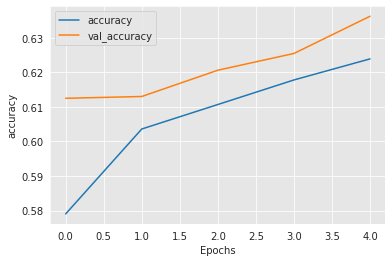

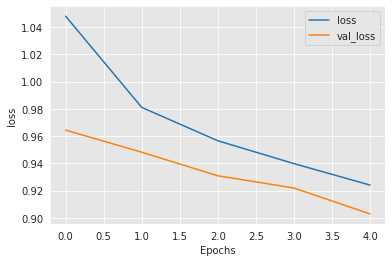

In [50]:
#Generating Accuracy and Loss Graph
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [51]:
predTest = predict_results(X_testTokenized, LstModel)
predTrain = predict_results(X_trainTokenized, LstModel)

print(f'\nClassification Report:\n{classification_report(y_test,predTest)}')
print("-------------------------------")
print(f'Accuracy Test: {accuracy_score(y_test,predTest)*100} %')
print(f'Accuracy Train: {accuracy_score(y_train,predTrain)*100} %')



Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.18      0.27      1414
           1       0.51      0.47      0.49      5455
           2       0.71      0.83      0.76     15917
           3       0.53      0.52      0.53      6585
           4       0.62      0.27      0.37      1841

    accuracy                           0.64     31212
   macro avg       0.58      0.45      0.48     31212
weighted avg       0.62      0.64      0.62     31212

-------------------------------
Accuracy Test: 63.55568371139305 %
Accuracy Train: 64.46959502755351 %


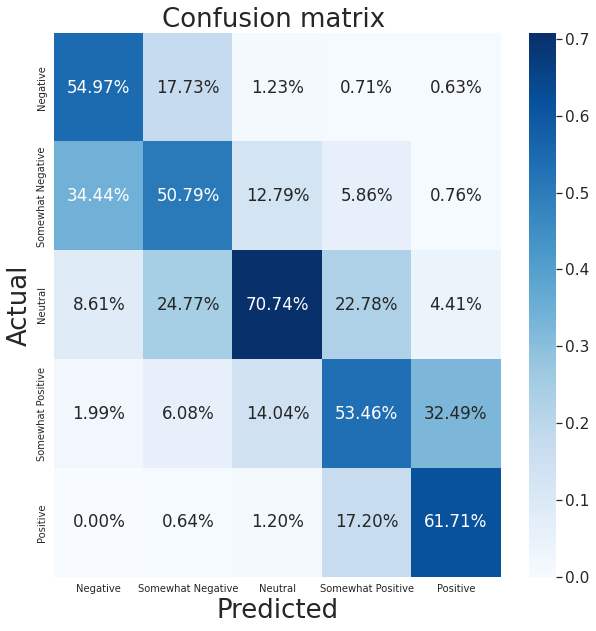

In [52]:
confusionMatrix(y_test, predTest)

#CNN+LSTM

In [53]:
#CNN + LSTM Model
def built_modelCnn():
  model=Sequential()
  model.add(Embedding(len(embedding_matrix), 300, weights=[embedding_matrix], 
                            input_length=30, trainable=False))
  model.add(Conv1D(64, kernel_size=3, padding="same", activation="relu"))
  model.add(MaxPooling1D(pool_size=3))
  model.add(Dropout(0.2))
  model.add(Bidirectional(LSTM(256,dropout=0.6, recurrent_dropout=0.2, return_sequences=False)))
  model.add(Dense(num_classes,activation='softmax'))
  model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),optimizer="adam",metrics=['accuracy'])
  return model 


In [54]:
#Fitting Hybrid Model
CnnModel = built_modelCnn()
CnnModel.summary()
history=CnnModel.fit(X_trainTokenized, y_train, validation_split=0.2,epochs=5, batch_size=256, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 300)           3447600   
                                                                 
 conv1d (Conv1D)             (None, 30, 64)            57664     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 64)           0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 10, 64)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              657408    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 5)                

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


391/391 [==============================] - 44s 82ms/step - loss: 1.0435 - accuracy: 0.5802 - val_loss: 0.9591 - val_accuracy: 0.6095
Epoch 2/5
391/391 [==============================] - 32s 83ms/step - loss: 0.9373 - accuracy: 0.6170 - val_loss: 0.9139 - val_accuracy: 0.6272
Epoch 3/5
391/391 [==============================] - 32s 82ms/step - loss: 0.9037 - accuracy: 0.6310 - val_loss: 0.8957 - val_accuracy: 0.6358
Epoch 4/5
391/391 [==============================] - 29s 73ms/step - loss: 0.8756 - accuracy: 0.6402 - val_loss: 0.8807 - val_accuracy: 0.6425
Epoch 5/5
391/391 [==============================] - 29s 74ms/step - loss: 0.8547 - accuracy: 0.6510 - val_loss: 0.8707 - val_accuracy: 0.6447


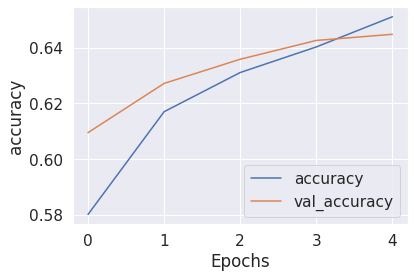

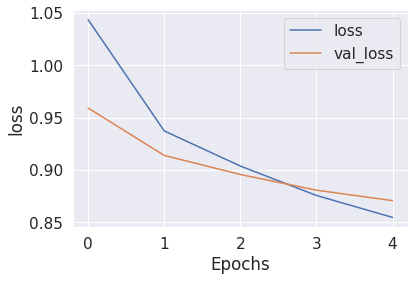

In [55]:
#Generating Accuracy and Loss Graph

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [56]:
#Prediction and results
predTestCnn = predict_results(X_testTokenized, CnnModel)
predTrainCnn = predict_results(X_trainTokenized, CnnModel)

print(f'\nClassification Report:\n{classification_report(y_test,predTestCnn)}')
print("-------------------------------------")
print(f'Accuracy Test: {accuracy_score(y_test,predTestCnn)*100} %')
print(f'Accuracy Train: {accuracy_score(y_train,predTrainCnn)*100} %')


Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.30      0.38      1414
           1       0.51      0.56      0.53      5455
           2       0.74      0.79      0.76     15917
           3       0.56      0.53      0.54      6585
           4       0.55      0.39      0.45      1841

    accuracy                           0.65     31212
   macro avg       0.58      0.51      0.54     31212
weighted avg       0.64      0.65      0.64     31212

-------------------------------------
Accuracy Test: 64.69947456106627 %
Accuracy Train: 67.32266435986159 %


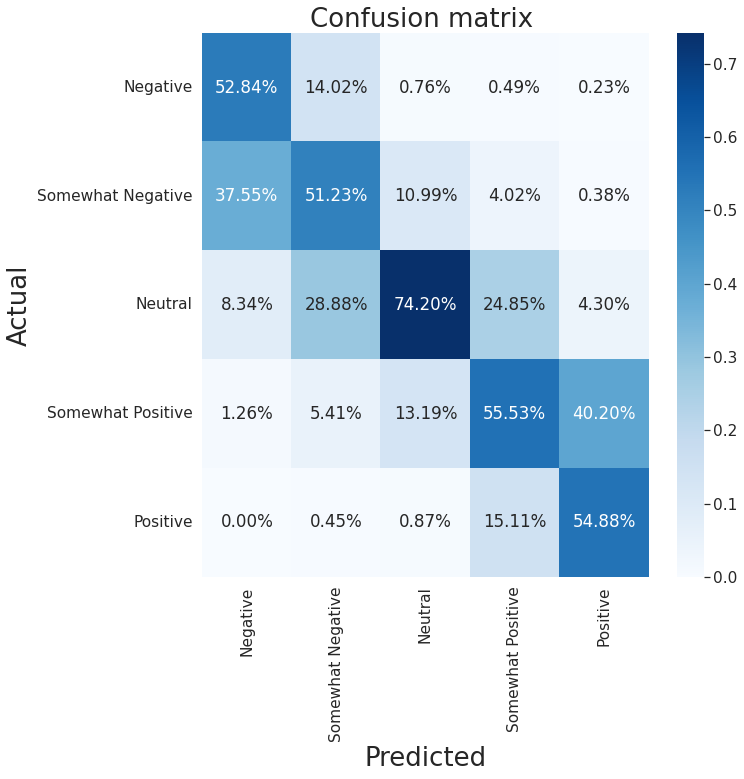

In [57]:
confusionMatrix(y_test, predTestCnn)

#SVC

Best parameter set: {'clf__loss': 'squared_hinge', 'clf__penalty': 'l2'}
Calculating results with best Hyperparameters...

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.28      0.36      1414
           1       0.53      0.41      0.46      5455
           2       0.69      0.84      0.76     15916
           3       0.55      0.47      0.51      6586
           4       0.57      0.30      0.39      1841

    accuracy                           0.63     31212
   macro avg       0.57      0.46      0.50     31212
weighted avg       0.61      0.63      0.61     31212

----------------------------
Accuracy Test: 63.081507112648985 %
Accuracy Train: 69.3723567858516 %
----------------------------


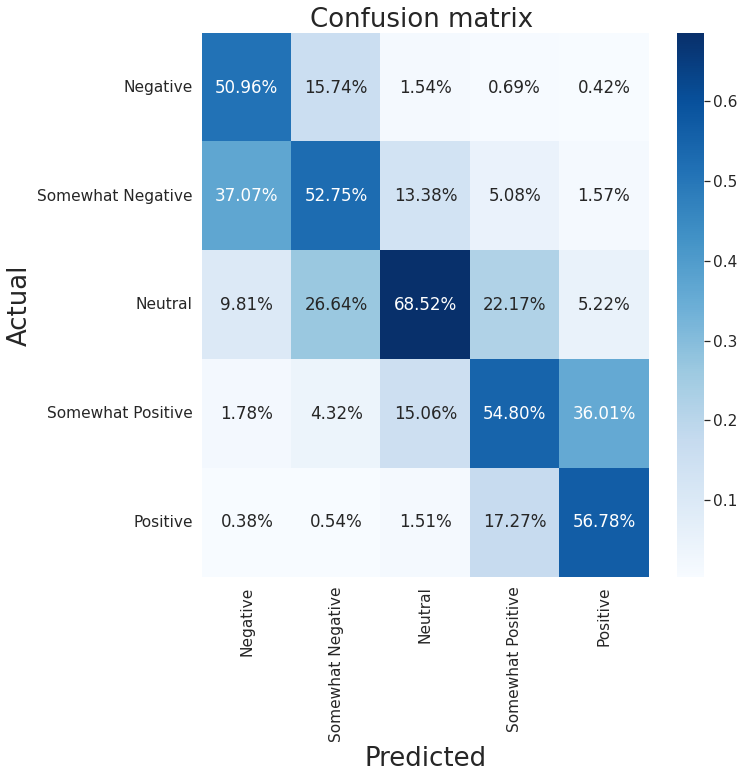

In [ ]:
#Use of Pipeline to preprocess data with TFIDF
warnings.filterwarnings("ignore")

param_grid = {'clf__loss': ['hinge', 'squared_hinge'],
              'clf__penalty': ['l2','l1']}

SVCclassifier = LinearSVC()
SVCmodel = Pipeline([('tfidf', vectorizer),
                    ('clf', SVCclassifier)])

clfSVC = gridSearchOptimization(SVCmodel, param_grid, X_train, y_train)

print("Calculating results with best Hyperparameters...")
#Prediction on Test and Train 
SVCpred = clfSVC.predict(X_test)
SVCpredTrain = clfSVC.predict(X_train)

#Confusion Matrix

print(f'\nClassification Report:\n{classification_report(y_test,SVCpred)}')
print("----------------------------")
print(f'Accuracy Test: {accuracy_score(y_test,SVCpred)*100} %')
print(f'Accuracy Train: {accuracy_score(y_train,SVCpredTrain)*100} %')
print("----------------------------")

confusionMatrix(y_test, SVCpred)

In [ ]:
pre = clfSVC.predict(["I think this is my first review. This series is so good I had to write one. I can understand the good score. I have tried on 2 separate occasions to watch this show. Haven't even gotten past the 2nd episode because it is so good."])
print(f'Prediction: {convert_review(pre[0])}')

Prediction: somewhat positive


#Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

Best parameter set: {'clf__alpha': 0.001}
Calculating results with best Hyperparameters...

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.18      0.26      1414
           1       0.52      0.32      0.40      5455
           2       0.63      0.86      0.73     15916
           3       0.52      0.40      0.45      6586
           4       0.57      0.18      0.28      1841

    accuracy                           0.60     31212
   macro avg       0.55      0.39      0.42     31212
weighted avg       0.58      0.60      0.56     31212

----------------------------
Accuracy Test Naive Bayes: 59.816737152377286 %
Accuracy Train Naive Bayes: 64.50804177880303 %
----------------------------


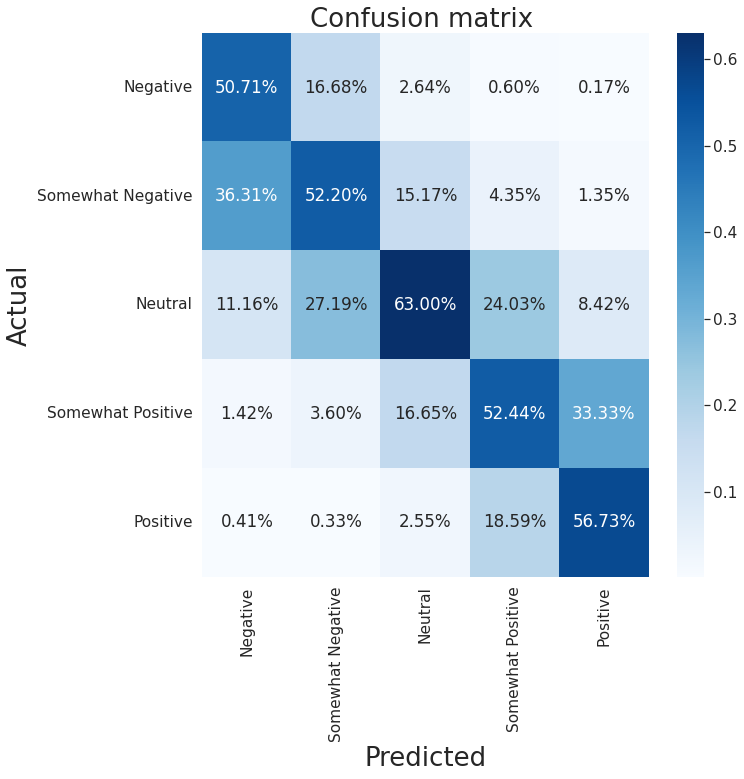

In [ ]:
warnings.filterwarnings("ignore")


param_grid = {'clf__alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}

NBCategorical = MultinomialNB()

NBmodel = Pipeline([('tfidf', vectorizer),
                    ('clf', NBCategorical)])

# Train the Model
clfNB = gridSearchOptimization(NBmodel, param_grid, X_train, y_train)

print("Calculating results with best Hyperparameters...")
#Prediction on Test and Train 
NBpred = clfNB.predict(X_test)
NBpredTrain = clfNB.predict(X_train)



print(f'\nClassification Report:\n{classification_report(y_test,NBpred)}')
print("----------------------------")
print(f'Accuracy Test Naive Bayes: {accuracy_score(y_test,NBpred)*100} %')
print(f'Accuracy Train Naive Bayes: {accuracy_score(y_train,NBpredTrain)*100} %')
print("----------------------------")

confusionMatrix(y_test, NBpred)

In [ ]:
pre = clfNB.predict(["I think this is my first review. This series is so bad I had to write one. I don't understand the good score. I have tried on 2 separate occasions to watch this show. Haven't even gotten past the 2nd episode because it is SO BORING."])
print(f'Prediction: {convert_review(pre[0])}')

Prediction: neutral


#LDA Allocazione latente di Dirichlet

Tecnica utilizzata per la modellazione degli argomenti. Assegnare etichette di categorie (clustering) per apprendimento senza supervisione, quindi in argomenti non etichettati.

In [69]:
CountVectorizer,
count = CountVectorizer(stop_words='english',
                        max_df=.1,
                        max_features=5000)
X= count.fit_transform(dfTrain['clean_text'])

In [70]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5,
                                random_state=123,
                                learning_method='batch')

X_topics = lda.fit_transform(X)

In [71]:
n_top_words = 5
feature_names = count.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
  print("Topic %d: " % (topic_idx + 1))
  print(" ".join([feature_names[i]
                  for i in topic.argsort()\
                  [:-n_top_words -1 :-1]]))

Topic 1: 
story character love laugh act
Topic 2: 
comedy movie end best plot
Topic 3: 
film movie time work like
Topic 4: 
film make movie bad long
Topic 5: 
life movie funny good performance


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [72]:
love = X_topics[:, 3].argsort()[::-1]
for iter_idx, movie_idx in enumerate(love[:3]):
  print('\n Love Movie #%d: ' % (iter_idx +1))
  print(dfTrain['clean_text'][movie_idx][:300], '...')


 Love Movie #1: 
really salute haneke adapt elfriede jelinek novel make film nearly graphic much powerful brutally shock difficult watch ...

 Love Movie #2: 
really salute haneke adapt elfriede jelinek novel make film nearly graphic much powerful brutally shock difficult watch ...

 Love Movie #3: 
salute haneke adapt elfriede jelinek novel make film nearly graphic much powerful brutally shock difficult watch ...


#Results

In [64]:
#Create vocabulary for Test
unique_wordsTest, len_maxTest = vocabulary_size(dfTest['pre_processing'])

100%|██████████| 66292/66292 [00:00<00:00, 1246687.89it/s]


In [65]:
#Tokenization of Test set for Neural Network
sequences = tokenizer.texts_to_sequences(dfTest['clean_text'])
test=sequence.pad_sequences(sequences, maxlen=30)

In [ ]:
#Creation submission LSTM model
test_id = dfTest['PhraseId']
y_pred=LstModel.predict(test)
predLSTM = from_soft_to_class(y_pred)


submission = pd.DataFrame(list(zip(test_id, predLSTM)),
               columns =['PhraseId', 'Sentiment'])
submission.head(20)


submission.to_csv('./LSTMsubmission.csv', index=False)

In [67]:
#Creation submission CNN-LSTM model
test_id = dfTest['PhraseId']
y_pred=CnnModel.predict(test)

predCnn = from_soft_to_class(y_pred)


submissionHyb = pd.DataFrame(list(zip(test_id, predCnn)),
               columns =['PhraseId', 'Sentiment'])
submissionHyb.head(20)


submissionHyb.to_csv('./CNN-LSTMsubmission.csv', index=False)

In [ ]:
#Creation submission Logistic Regression model
testLR = clfLR.predict(dfTest['clean_text'])

submissionLR = pd.DataFrame(list(zip(test_id, testLR)),
               columns =['PhraseId', 'Sentiment'])
submissionLR.head(20)


submissionLR.to_csv('./LogisticRegression-submission.csv', index=False)

In [ ]:
#Creation submission Support Vector classification model
testSVC = clfSVC.predict(dfTest['clean_text'])

submissionSVC = pd.DataFrame(list(zip(test_id, testSVC)),
               columns =['PhraseId', 'Sentiment'])
submissionSVC.head(20)


submissionSVC.to_csv('./SVC-submission.csv', index=False)

In [ ]:
#Creation submission Naive Bayes model
testNB = clfNB.predict(dfTest['clean_text'])

submissionNB = pd.DataFrame(list(zip(test_id, testNB)),
               columns =['PhraseId', 'Sentiment'])
submissionNB.head(20)


submissionNB.to_csv('./NB-submission.csv', index=False)